NBEATS EXAMPLE

https://subhayo.wordpress.com/2019/05/15/time-series-analysis-of-monthly-milk-production/

It's a toy example to show how to do time series forecasting using N-Beats.

In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F

from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save

warnings.filterwarnings(action='ignore', message='Setting attributes')

In [ ]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

            milk_production_pounds
month                             
1962-01-01                     589
1962-02-01                     561
1962-03-01                     640
1962-04-01                     656
1962-05-01                     727
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @140254911406432
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @140252272164672
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @140252271756192
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @140254911407488
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @14025227175748

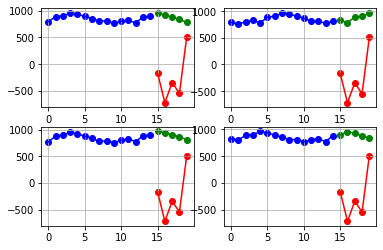

epoch = 0000, grad_step = 000012, tr_loss (epoch) = 1397.928, te_loss (epoch) = 1543.417


KeyboardInterrupt: 

In [3]:
def main():
    forecast_length = 5
    backcast_length = 3 * forecast_length
    batch_size = 10  # greater than 4 for viz

    milk = pd.read_csv('data/milk.csv', index_col=0, parse_dates=True)
    print(milk.head())
    milk = milk.values.flatten()  # just keep np array here for simplicity.

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(milk) - forecast_length):
        x.append(milk[epoch - backcast_length:epoch])
        y.append(milk[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]

    # normalization.
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant

    # model
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        hidden_layer_units=128,
    )
    optimiser = optim.Adam(lr=1e-4, params=net.parameters())

    grad_step = 0
    for epoch in range(1000):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            with torch.no_grad():
                save(net, optimiser, grad_step)
            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')




if __name__ == '__main__':
    main()

In [4]:
import warnings

import numpy as np

from nbeats_keras.model import NBeatsNet as NBeatsKeras
from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch

warnings.filterwarnings(action='ignore', message='Setting attributes')



# https://keras.io/layers/recurrent/
# At the moment only Keras supports input_dim > 1. In the original paper, input_dim=1.
num_samples, time_steps, input_dim, output_dim = 50_000, 10, 1, 1

# This example is for both Keras and Pytorch. In practice, choose the one you prefer.
for BackendType in [NBeatsKeras, NBeatsPytorch]:
    # NOTE: If you choose the Keras backend with input_dim>1, you have 
    # to set the value here too (in the constructor).
    backend = BackendType(
        backcast_length=time_steps, forecast_length=output_dim,
        stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),
        nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
        hidden_layer_units=64
    )

    # Definition of the objective function and the optimizer.
    backend.compile(loss='mae', optimizer='adam')

    # Definition of the data. The problem to solve is to find f such as | f(x) - y | -> 0.
    # where f = np.mean.
    x = np.random.uniform(size=(num_samples, time_steps, input_dim))
    y = np.mean(x, axis=1, keepdims=True)

    # Split data into training and testing datasets.
    c = num_samples // 10
    x_train, y_train, x_test, y_test = x[c:], y[c:], x[:c], y[:c]
    test_size = len(x_test)

    # Train the model.
    print('Training...')
    backend.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=128)

    # Save the model for later.
    backend.save('n_beats_model.h5')

    # Predict on the testing set (forecast).
    predictions_forecast = backend.predict(x_test)
    np.testing.assert_equal(predictions_forecast.shape, (test_size, backend.forecast_length, output_dim))

    # Predict on the testing set (backcast).
    predictions_backcast = backend.predict(x_test, return_backcast=True)
    np.testing.assert_equal(predictions_backcast.shape, (test_size, backend.backcast_length, output_dim))

    # Load the model.
    model_2 = BackendType.load('n_beats_model.h5')

    np.testing.assert_almost_equal(predictions_forecast, model_2.predict(x_test))


    

Training...
Epoch 1/20
352/352 [==============================] - 3s 5ms/step - loss: 0.0182 - root_mean_squared_error: 0.1350 - val_loss: 3.3553e-04 - val_root_mean_squared_error: 0.0183
Epoch 2/20
352/352 [==============================] - 2s 5ms/step - loss: 2.2924e-04 - root_mean_squared_error: 0.0151 - val_loss: 1.3419e-04 - val_root_mean_squared_error: 0.0116
Epoch 3/20
352/352 [==============================] - 2s 4ms/step - loss: 1.0704e-04 - root_mean_squared_error: 0.0103 - val_loss: 7.6270e-05 - val_root_mean_squared_error: 0.0087
Epoch 4/20
352/352 [==============================] - 2s 4ms/step - loss: 6.1940e-05 - root_mean_squared_error: 0.0079 - val_loss: 4.9154e-05 - val_root_mean_squared_error: 0.0070
Epoch 5/20
352/352 [==============================] - 2s 4ms/step - loss: 4.1569e-05 - root_mean_squared_error: 0.0064 - val_loss: 3.4826e-05 - val_root_mean_squared_error: 0.0059
Epoch 6/20
352/352 [==============================] - 2s 4ms/step - loss: 3.3077e-05 - root_

ValueError: in user code:

    File "/home/ttadayon/miniconda3/envs/BEATSpy38/lib/python3.8/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/home/ttadayon/miniconda3/envs/BEATSpy38/lib/python3.8/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ttadayon/miniconda3/envs/BEATSpy38/lib/python3.8/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/home/ttadayon/miniconda3/envs/BEATSpy38/lib/python3.8/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/home/ttadayon/miniconda3/envs/BEATSpy38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ttadayon/miniconda3/envs/BEATSpy38/lib/python3.8/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "forecast" is incompatible with the layer: expected shape=(None, 30, 1), found shape=(None, 10, 1)


In [9]:
x


array([[[0.87047269],
        [0.72843072],
        [0.13205862],
        ...,
        [0.36787164],
        [0.75778189],
        [0.00537452]],

       [[0.53974646],
        [0.12578139],
        [0.84612746],
        ...,
        [0.77979845],
        [0.62472023],
        [0.04808803]],

       [[0.10055624],
        [0.05686785],
        [0.4537616 ],
        ...,
        [0.03960269],
        [0.0295037 ],
        [0.56554616]],

       ...,

       [[0.51409949],
        [0.41229587],
        [0.98462146],
        ...,
        [0.12833476],
        [0.78094674],
        [0.65397752]],

       [[0.32253766],
        [0.08068164],
        [0.19169569],
        ...,
        [0.15111459],
        [0.05810606],
        [0.90188125]],

       [[0.60543364],
        [0.79428056],
        [0.98173591],
        ...,
        [0.01512733],
        [0.32182371],
        [0.18434696]]])